In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tabulate import tabulate
import csv

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set paths for dataset splits
train_dir = 'I:/RICE/final_rice_data/train'
val_dir = 'I:/RICE/final_rice_data/val'
test_dir = 'I:/RICE/final_rice_data/test'

In [19]:
# Function to count images in a directory
def count_images_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each directory
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

# Display the counts
print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the validation set: {val_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 10000
Total number of images in the validation set: 1250
Total number of images in the test set: 1250


In [20]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(20),            # Random rotation
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

In [21]:
# Normalization for validation and test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [23]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
# Define the VGG16 model architecture
class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)  # Load VGG16 with pretrained weights
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)  # Change the last layer to match the number of classes

    def forward(self, x):
        return self.vgg16(x)

num_classes = 5  # Number of classes
model = VGG16Model(num_classes).to(device)

In [25]:
# Display model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [27]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc= "Training", leave = False):
        images, labels = images.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

    train_loss = running_loss / len(train_loader)  # Average loss
    train_accuracy = 100*correct / total  # Accuracy
    return train_loss, train_accuracy


In [28]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [29]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []  # To store training accuracy

    best_val_accuracy = 0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Append to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)  # Store training accuracy

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Accuracy: {train_accuracy:.4f} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation Loss: {val_loss:.4f}")

        # Check if we have a new best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_crack_detection_model.pth')
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}%")
        else:
            epochs_without_improvement += 1
        
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch + 1}.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [30]:
# Train and evaluate the model
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/30 - Training Accuracy: 41.6900 - Training Loss: 1.3557 - Validation Accuracy: 68.0800 - Validation Loss: 0.9704
Best model saved with accuracy: 68.0800%


Epoch 2/30 - Training Accuracy: 80.5900 - Training Loss: 0.5286 - Validation Accuracy: 91.6000 - Validation Loss: 0.3020
Best model saved with accuracy: 91.6000%


Epoch 3/30 - Training Accuracy: 92.9100 - Training Loss: 0.2027 - Validation Accuracy: 94.5600 - Validation Loss: 0.1669
Best model saved with accuracy: 94.5600%


Epoch 4/30 - Training Accuracy: 95.1800 - Training Loss: 0.1353 - Validation Accuracy: 96.0800 - Validation Loss: 0.1254
Best model saved with accuracy: 96.0800%


Epoch 5/30 - Training Accuracy: 96.0100 - Training Loss: 0.1063 - Validation Accuracy: 96.1600 - Validation Loss: 0.1032
Best model saved with accuracy: 96.1600%


Epoch 6/30 - Training Accuracy: 96.4000 - Training Loss: 0.0970 - Validation Accuracy: 96.9600 - Validation Loss: 0.0944
Best model saved with accuracy: 96.9600%


Epoch 7/30 - Training Accuracy: 97.4200 - Training Loss: 0.0795 - Validation Accuracy: 97.2800 - Validation Loss: 0.0743
Best model saved with accuracy: 97.2800%


Epoch 8/30 - Training Accuracy: 97.3200 - Training Loss: 0.0728 - Validation Accuracy: 97.2800 - Validation Loss: 0.0740


Epoch 9/30 - Training Accuracy: 97.7800 - Training Loss: 0.0646 - Validation Accuracy: 97.3600 - Validation Loss: 0.0654
Best model saved with accuracy: 97.3600%


Epoch 10/30 - Training Accuracy: 97.8800 - Training Loss: 0.0596 - Validation Accuracy: 97.8400 - Validation Loss: 0.0611
Best model saved with accuracy: 97.8400%


Epoch 11/30 - Training Accuracy: 97.6300 - Training Loss: 0.0630 - Validation Accuracy: 97.7600 - Validation Loss: 0.0603


Epoch 12/30 - Training Accuracy: 98.1000 - Training Loss: 0.0524 - Validation Accuracy: 97.9200 - Validation Loss: 0.0536
Best model saved with accuracy: 97.9200%


Epoch 13/30 - Training Accuracy: 98.2000 - Training Loss: 0.0508 - Validation Accuracy: 98.3200 - Validation Loss: 0.0551
Best model saved with accuracy: 98.3200%


Epoch 14/30 - Training Accuracy: 98.3200 - Training Loss: 0.0451 - Validation Accuracy: 98.0800 - Validation Loss: 0.0551


Epoch 15/30 - Training Accuracy: 98.4000 - Training Loss: 0.0441 - Validation Accuracy: 98.4000 - Validation Loss: 0.0485
Best model saved with accuracy: 98.4000%


Epoch 16/30 - Training Accuracy: 98.4000 - Training Loss: 0.0448 - Validation Accuracy: 98.4000 - Validation Loss: 0.0439


Epoch 17/30 - Training Accuracy: 98.7100 - Training Loss: 0.0416 - Validation Accuracy: 98.2400 - Validation Loss: 0.0462


Epoch 18/30 - Training Accuracy: 98.6200 - Training Loss: 0.0387 - Validation Accuracy: 98.4800 - Validation Loss: 0.0425
Best model saved with accuracy: 98.4800%


Epoch 19/30 - Training Accuracy: 98.8000 - Training Loss: 0.0367 - Validation Accuracy: 98.5600 - Validation Loss: 0.0443
Best model saved with accuracy: 98.5600%


Epoch 20/30 - Training Accuracy: 98.7000 - Training Loss: 0.0364 - Validation Accuracy: 98.5600 - Validation Loss: 0.0422


Epoch 21/30 - Training Accuracy: 98.9600 - Training Loss: 0.0301 - Validation Accuracy: 98.6400 - Validation Loss: 0.0402
Best model saved with accuracy: 98.6400%


Epoch 22/30 - Training Accuracy: 98.8400 - Training Loss: 0.0306 - Validation Accuracy: 98.6400 - Validation Loss: 0.0332


Epoch 23/30 - Training Accuracy: 98.9000 - Training Loss: 0.0293 - Validation Accuracy: 98.4800 - Validation Loss: 0.0418


Epoch 24/30 - Training Accuracy: 98.9800 - Training Loss: 0.0282 - Validation Accuracy: 98.7200 - Validation Loss: 0.0346
Best model saved with accuracy: 98.7200%


Epoch 25/30 - Training Accuracy: 99.0600 - Training Loss: 0.0292 - Validation Accuracy: 98.8800 - Validation Loss: 0.0308
Best model saved with accuracy: 98.8800%


Epoch 26/30 - Training Accuracy: 99.0900 - Training Loss: 0.0258 - Validation Accuracy: 98.9600 - Validation Loss: 0.0298
Best model saved with accuracy: 98.9600%


Epoch 27/30 - Training Accuracy: 99.0700 - Training Loss: 0.0269 - Validation Accuracy: 98.8800 - Validation Loss: 0.0282


Epoch 28/30 - Training Accuracy: 99.0600 - Training Loss: 0.0266 - Validation Accuracy: 98.8000 - Validation Loss: 0.0325


Epoch 29/30 - Training Accuracy: 99.0500 - Training Loss: 0.0261 - Validation Accuracy: 98.9600 - Validation Loss: 0.0272


Epoch 30/30 - Training Accuracy: 99.3300 - Training Loss: 0.0204 - Validation Accuracy: 99.0400 - Validation Loss: 0.0292
Best model saved with accuracy: 99.0400%


In [31]:
# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0477, Test Accuracy: 98.40%


In [32]:
# Save accuracy and loss to a CSV file
with open('vgg16_training_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])
    for epoch in range(len(train_losses)):  # Use len(train_losses) instead of num_epochs
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])

print("Training results saved to vgg16_training_results.csv")

Training results saved to vgg16_training_results.csv


In [33]:
# Optionally save the final model (this is optional since best model is already saved)
torch.save(model.state_dict(), 'vgg16_rice_model.pth')
print("Model training complete and saved as 'vgg16_rice_model.pth'.")

Model training complete and saved as 'vgg16_rice_model.pth'.


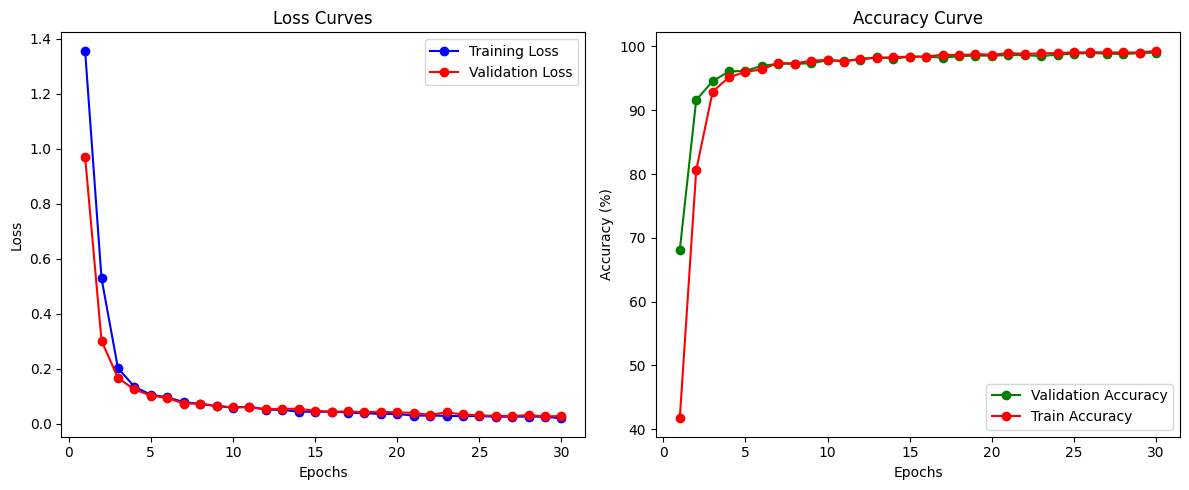

In [34]:
# Plotting accuracy and loss curves
def plot_curves(train_losses, val_losses, val_accuracies, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(train_losses, val_losses, val_accuracies, train_accuracies)